<a href="https://colab.research.google.com/github/iopebiel/machine_learning_fraud_credit_card/blob/logisticRegression/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bibliotecas

In [1]:
!pip install imblearn
import pandas as pd
import seaborn as sn
import kagglehub as kh
import os
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, matthews_corrcoef
import matplotlib.pyplot as plt

Download Arquivo CSV no repositório Credit Card Fraud na plataforma Kaggle

In [2]:
path = kh.dataset_download("mlg-ulb/creditcardfraud")

print("Caminho para o Dataset:", path)
os.listdir(path)

Caminho para o Dataset: /kaggle/input/creditcardfraud


['creditcard.csv']

In [3]:
data = pd.read_csv("../kaggle/input/creditcardfraud/creditcard.csv")
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


## Pré processamento dos dados

In [4]:
number_of_fraud = len(data[data.Class == 1])
number_of_normal= len(data[data.Class == 0])

print ("Fraude:", number_of_fraud)
print ("Legítima:",number_of_normal)

Fraude: 492
Legítima: 284315


In [5]:
X = data.drop("Class", axis=1)
y = data["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
counter = Counter(y_train)
print('Base de dados de treino antes do SMOTE:', counter)
counter = Counter(y_test)
print('Base de dados de teste', counter)

Base de dados de treino antes do SMOTE: Counter({0: 199020, 1: 344})
Base de dados de teste Counter({0: 85295, 1: 148})


##SMOTE 50:50

In [6]:
enn = EditedNearestNeighbours()
X_train_resampled, y_train_resampled = enn.fit_resample(X_train, y_train)
print('Base de treino depois do ENN:', Counter(y_train_resampled))

smt = SMOTE(random_state=42)
X_train_sm_5050, y_train_sm_5050 = smt.fit_resample(X_train_resampled, y_train_resampled)
counter = Counter(y_train_sm_5050)
print('Depois do SMOTE:', counter)

Base de treino depois do ENN: Counter({0: 198698, 1: 344})
Depois do SMOTE: Counter({0: 198698, 1: 198698})


##SMOTE 10 : 90

In [7]:
enn = EditedNearestNeighbours()
X_train_enn, y_train_enn = enn.fit_resample(X_train, y_train)
print('Depois do ENN:', Counter(y_train_enn))

smt = SMOTE(random_state=42, sampling_strategy=0.111)
X_train_sm_1090, y_train_sm_1090 = smt.fit_resample(X_train_enn, y_train_enn)
counter = Counter(y_train_sm_1090)
print('Depois do SMOTE:', counter)

Depois do ENN: Counter({0: 198698, 1: 344})
Depois do SMOTE: Counter({0: 198698, 1: 22055})


## Análise dos dados

##Estatísticas Descritivas

In [8]:
print("dataset original")
data[["Amount","Time"]].describe()

dataset original


,Amount,Time
count,284807.000000,284807.000000
mean,88.349619,94813.859575
std,250.120109,47488.145955
min,0.000000,0.000000
25%,5.600000,54201.500000
50%,22.000000,84692.000000
75%,77.165000,139320.500000
max,25691.160000,172792.000000


In [9]:
print("10 : 90")
X_train_sm_1090[["Amount","Time"]].describe()

10 : 90


,Amount,Time
count,220753.000000,220753.000000
mean,89.881463,93599.610449
std,247.855283,47639.513139
min,0.000000,0.000000
25%,5.000000,53043.811707
50%,22.520000,84518.000000
75%,80.820000,138685.000000
max,25691.160000,172792.000000


In [10]:
print("50 : 50")
X_train_sm_5050[["Amount","Time"]].describe()

50 : 50


,Amount,Time
count,397396.000000,397396.000000
mean,97.644135,88299.297217
std,228.396829,47967.359296
min,0.000000,0.000000
25%,3.570000,47193.911507
50%,24.990000,82071.500000
75%,99.990000,134259.100235
max,25691.160000,172792.000000


--------------------------

**Gráficos**

Base de dados original: Counter({0: 199020, 1: 344})


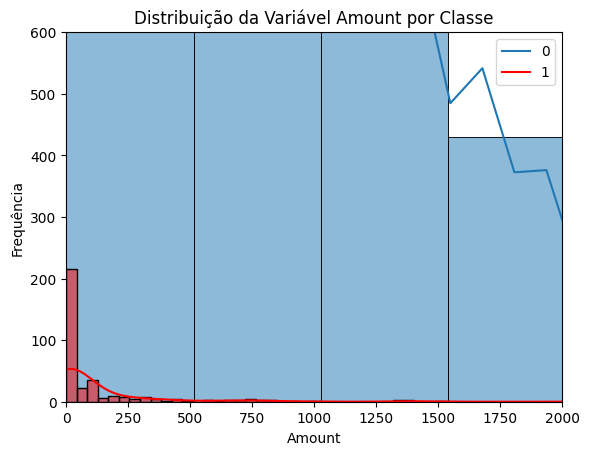

In [11]:
data_train = pd.concat([X_train, y_train], axis=1)
counter = Counter(data_train["Class"])
print('Base de dados original:', counter)

sn.histplot(data=data_train[data_train['Class'] == 0], x="Amount", bins=50, kde=True, stat='count')

sn.histplot(data=data_train[data_train['Class'] == 1], x="Amount", bins=50, color='red', linewidth=1, kde=True, stat='count')

plt.title('Distribuição da Variável Amount por Classe')
plt.legend(["0", "1"])

plt.xlabel('Amount')
plt.ylabel('Frequência')
plt.xlim(0, 2000)
plt.ylim(0, 600)
plt.show()

Subconjunto 10 : 90: Counter({0: 198698, 1: 22055})


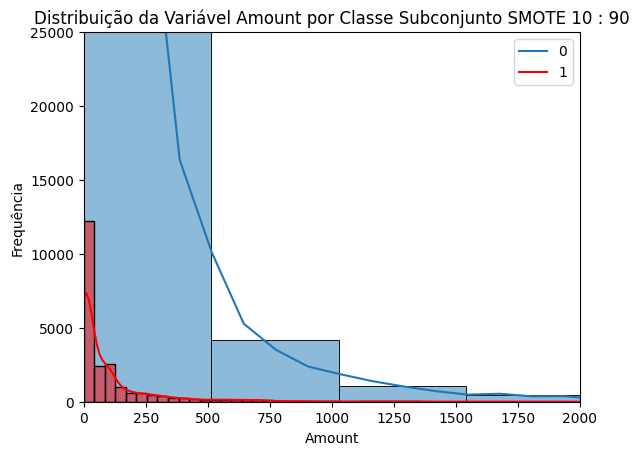

In [12]:
data_train_1090 = pd.concat([X_train_sm_1090, y_train_sm_1090], axis=1)
freq = data_train_1090.groupby(['Amount','Class']).size().reset_index(name='Frequência')
counter = Counter(data_train_1090["Class"])
print('Subconjunto 10 : 90:', counter)

sn.histplot(data=data_train_1090[data_train_1090['Class'] == 0], x="Amount", bins=50, kde=True, stat='count')

sn.histplot(data=data_train_1090[data_train_1090['Class'] == 1], x="Amount", bins=50, color='red', linewidth=1, kde=True, stat='count')

plt.legend(["0", "1"])

plt.title('Distribuição da Variável Amount por Classe Subconjunto SMOTE 10 : 90')
plt.xlabel('Amount')
plt.ylabel('Frequência')
plt.xlim(0, 2000)
plt.ylim(0, 25000)
plt.show()

Subconjunto 50 : 50: Counter({0: 198698, 1: 198698})


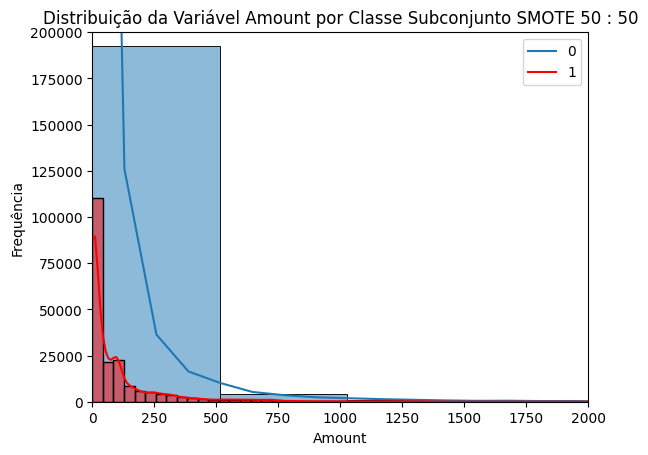

In [13]:
data_train_5050 = pd.concat([X_train_sm_5050, y_train_sm_5050], axis=1)
freq = data_train_5050.groupby(['Amount','Class']).size().reset_index(name='Frequência')

counter = Counter(data_train_5050["Class"])
print('Subconjunto 50 : 50:', counter)

sn.histplot(data=data_train_5050[data_train_5050['Class'] == 0], x="Amount", bins=50, kde=True, stat='count')

sn.histplot(data=data_train_5050[data_train_5050['Class'] == 1], x="Amount", bins=50, color='red',linewidth=1, kde=True, stat='count')

plt.legend(["0", "1"])
plt.title('Distribuição da Variável Amount por Classe Subconjunto SMOTE 50 : 50')
plt.xlabel('Amount')
plt.ylabel('Frequência')
plt.xlim(0, 2000)
plt.ylim(0, 200000)
plt.show()

#MODELO TREINAMENTO SEM SMOTE

#####**MODELO 1**

In [ ]:
model = LogisticRegression(solver='saga', max_iter=10000, class_weight={0: 1, 1: 10}, verbose=1, n_jobs=10) #Quanto maior o número de iterações, melhor o resultado
model.fit(X_train,y_train)
y_pred_rl = model.predict(X_train)

print(classification_report(y_train, y_pred_rl))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


In [ ]:
dft = pd.DataFrame(data = X_test)
print(dft)
resultado_rl = model.predict(dft)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .

NameError: name 'model' is not defined

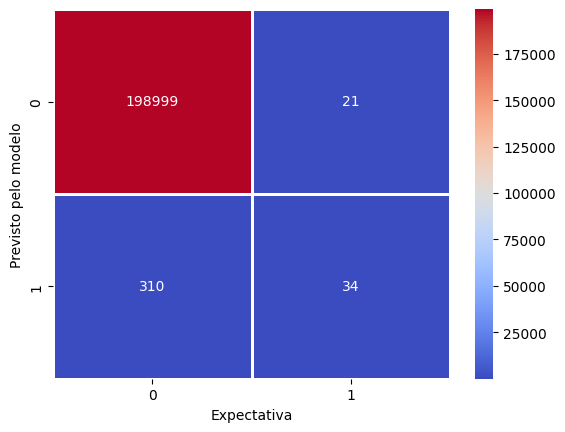


Métricas

Acurácia: 99.833972%
Precisão: 61.818182%
Recall:  9.883721%
F1 Score:  17.042607%
MCC:  24.673989%


In [ ]:
cf_matrix = confusion_matrix(y_train, y_pred_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print("\nMétricas\n")
print(f'Acurácia: {accuracy_score(y_train, y_pred_rl):%}')
print(f'Precisão: {precision_score(y_train, y_pred_rl):%}')
print(f'Recall:  {recall_score(y_train, y_pred_rl):%}')
print(f'F1 Score:  {f1_score(y_train, y_pred_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_train, y_pred_rl):%}')

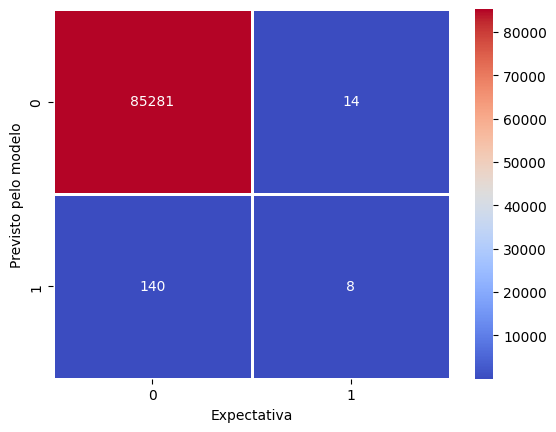


Métricas

Acurácia: 99.819763%
Precisão: 36.363636%
Recall:  5.405405%
F1 Score:  9.411765%
MCC:  13.967108%


In [ ]:
cf_matrix = confusion_matrix(y_test, resultado_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print("\nMétricas\n")
print(f'Acurácia: {accuracy_score(y_test, resultado_rl):%}')
print(f'Precisão: {precision_score(y_test, resultado_rl):%}')
print(f'Recall:  {recall_score(y_test, resultado_rl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_rl):%}')

0.5493658461344307 0.5269449589104902


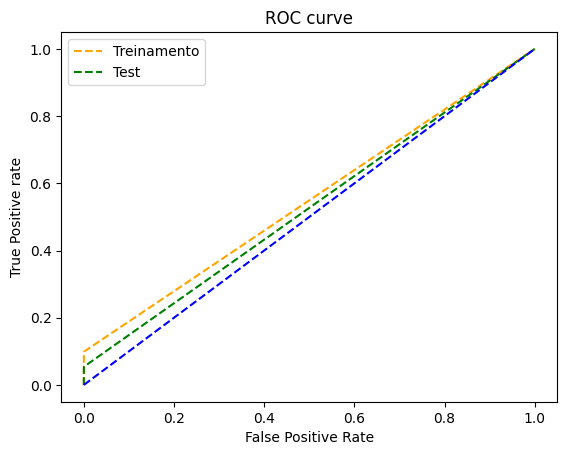

In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_train, y_pred_rl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_rl, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


from sklearn.metrics import roc_auc_score

auc_score1 = roc_auc_score(y_train, y_pred_rl)
auc_score2 = roc_auc_score(y_test, resultado_rl)

print(auc_score1, auc_score2)

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#####**MODELO 2**

In [25]:
from sklearn.metrics import classification_report

model = cuLogisticRegression(solver='qn', verbose=True)  # qn é equivalente ao saga #Epoch:387
model.fit(X_train, y_train)
y_pred_curl = model.predict(X_train)

print(classification_report(y_train, y_pred_curl))

[2025-06-27 02:18:24.261] [CUML] [debug] CY::Estimator parameters:
[2025-06-27 02:18:24.264] [CUML] [debug] {'C': 1.0,
 '_full_kwargs': {'solver': 'qn', 'verbose': True},
 '_input_mem_type': None,
 '_input_type': None,
 '_verbose': 5,
 'class_weight': CumlArrayDescriptorMeta(input_type=None, values={None: None}),
 'fit_intercept': True,
 'handle': <pylibraft.common.handle.Handle object at 0x7e2f30da7ed0>,
 'l1_ratio': None,
 'linesearch_max_iter': 50,
 'max_iter': 1000,
 'n_features_in_': None,
 'output_mem_type': <MemoryType.device: 1>,
 'output_type': 'input',
 'penalty': 'l2',
 'solver': 'qn',
 'solver_model': QN(),
 'target_dtype': None,
 'tol': 0.0001,
 'verb_prefix': 'CY::'}
[2025-06-27 02:18:24.282] [CUML] [debug] CY::Setting loss to sigmoid
[2025-06-27 02:18:24.282] [CUML] [debug] CY::Calling QN fit sigmoid
[2025-06-27 02:18:24.422] [CUML] [debug] Running L-BFGS
[2025-06-27 02:18:24.424] [CUML] [debug] 0000: f(x)=0.69314718 conv.crit=68251.42655423 (gnorm=47308.28388526, fmag=0

In [26]:
dft = pd.DataFrame(data = X_test)
print(dft)
resultado_curl = model.predict(dft)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .

In [27]:
from sklearn.metrics import log_loss
from sklearn.datasets import make_classification

# Obter probabilidades preditas
#y_prob = model.predict_proba(X_test)  # probabilidade da classe 1

# Calcular log loss
loss = log_loss(y_test, resultado_curl)
print(f"Log loss: {loss}")

Log loss: 0.03501308745358593


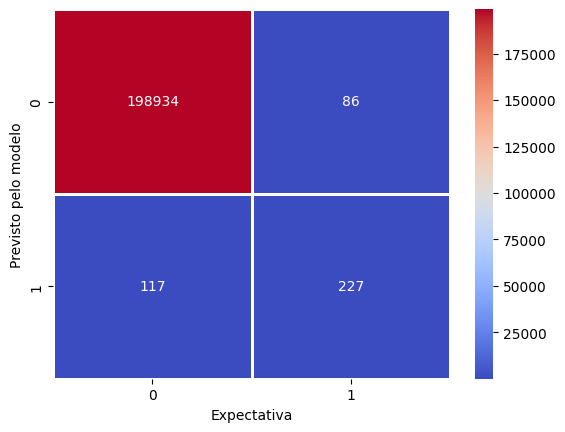


Métricas:

Acurácia: 99.898176%
Precisão: 72.523962%
Recall:  65.988372%
F1 Score:  69.101979%
MCC:  0.6912834510530647


In [28]:
cf_matrix = confusion_matrix(y_train, y_pred_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print("\nMétricas:\n")
print(f'Acurácia: {accuracy_score(y_train, y_pred_curl):%}')
print(f'Precisão: {precision_score(y_train, y_pred_curl):%}')
print(f'Recall:  {recall_score(y_train, y_pred_curl):%}')
print(f'F1 Score:  {f1_score(y_train, y_pred_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_train, y_pred_curl)}')

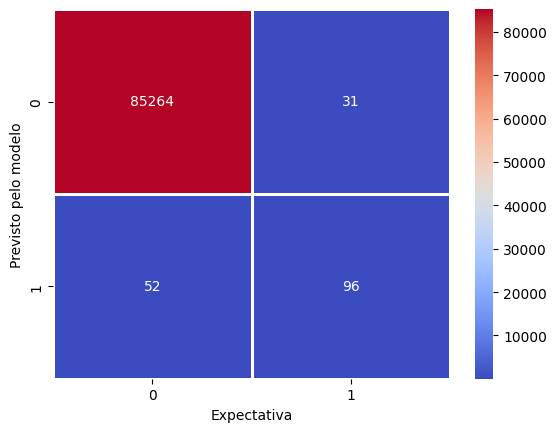


Métricas:

Acurácia: 99.902859%
Precisão: 75.590551%
Recall:  64.864865%
F1 Score:  69.818182%
MCC:  0.6997479760402862


In [29]:
cf_matrix = confusion_matrix(y_test, resultado_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print("\nMétricas:\n")
print(f'Acurácia: {accuracy_score(y_test, resultado_curl):%}')
print(f'Precisão: {precision_score(y_test, resultado_curl):%}')
print(f'Recall:  {recall_score(y_test, resultado_curl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_curl)}')

0.8297258017775472 0.8241426020662789


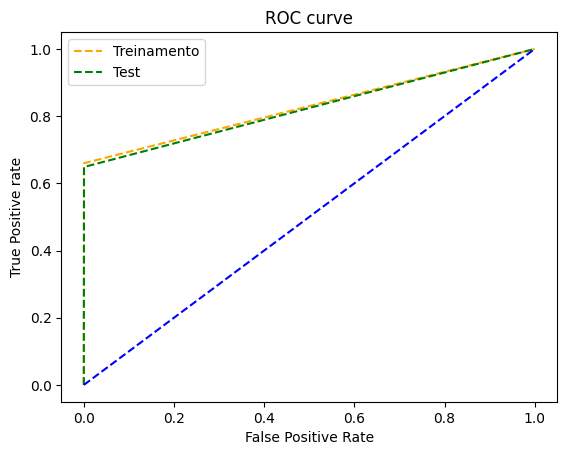

In [30]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_train, y_pred_curl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_curl, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_train, y_pred_curl)
auc_score2 = roc_auc_score(y_test, resultado_curl)

print(auc_score1, auc_score2)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#MODELO TREINAMENTO 10 : 90

#####**MODELO 1**

In [ ]:
model = LogisticRegression(solver='saga', max_iter=6000, class_weight={0: 1, 1: 10}, verbose=1, n_jobs=100) #Quanto maior o número de iterações, melhor o resultado
model.fit(X_train_sm_1090, y_train_sm_1090)
y_pred_rl = model.predict(X_train_sm_1090)

print(classification_report(y_train_sm_1090, y_pred_rl))

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.


convergence after 5828 epochs took 940 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    198698
           1       0.91      0.87      0.89     22055

    accuracy                           0.98    220753
   macro avg       0.95      0.93      0.94    220753
weighted avg       0.98      0.98      0.98    220753



In [ ]:
dft = pd.DataFrame(data = X_test)
print(dft)
resultado_rl = model.predict(dft)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .

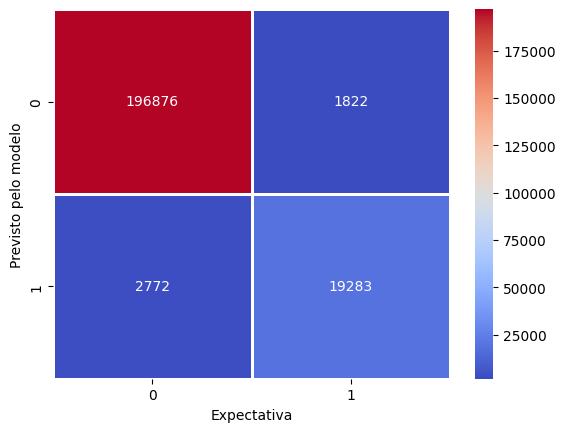


Métricas

Acurácia: 97.918941%
Precisão: 91.366975%
Recall:  87.431421%
F1 Score:  89.355885%
F1 Score:  88.229492%
MCC:  88.229492%


In [ ]:
cf_matrix = confusion_matrix(y_train_sm_1090, y_pred_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print("\nMétricas\n")
print(f'Acurácia: {accuracy_score(y_train_sm_1090, y_pred_rl):%}')
print(f'Precisão: {precision_score(y_train_sm_1090, y_pred_rl):%}')
print(f'Recall:  {recall_score(y_train_sm_1090, y_pred_rl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_1090, y_pred_rl):%}')
print(f'F1 Score:  {matthews_corrcoef(y_train_sm_1090, y_pred_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_1090, y_pred_rl):%}')

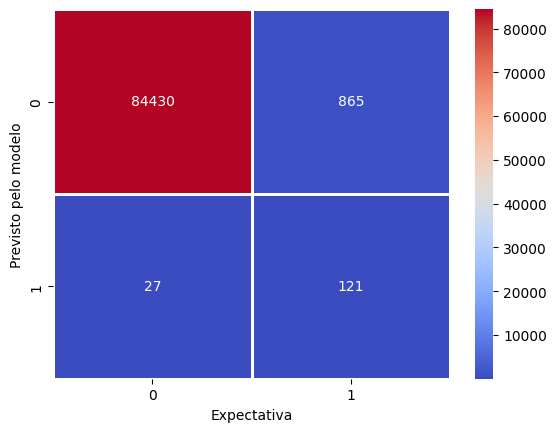


Métricas

Acurácia: 98.956029%
Precisão: 12.271805%
Recall:  81.756757%
F1 Score:  21.340388%
MCC:  31.436866%


In [ ]:
cf_matrix = confusion_matrix(y_test, resultado_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print("\nMétricas\n")
print(f'Acurácia: {accuracy_score(y_test, resultado_rl):%}')
print(f'Precisão: {precision_score(y_test, resultado_rl):%}')
print(f'Recall:  {recall_score(y_test, resultado_rl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_rl):%}')

0.9325722598756307 0.903713146583479


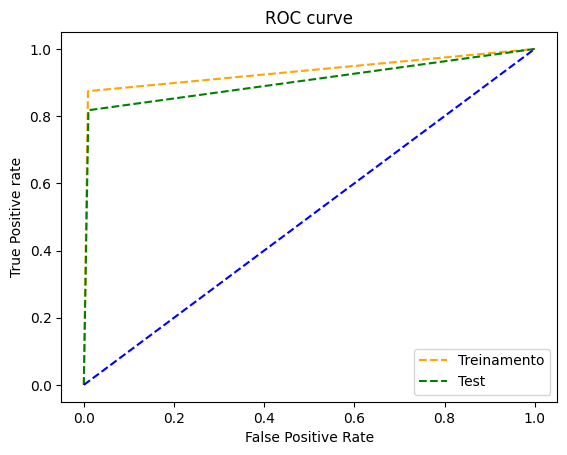

In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_1090, y_pred_rl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_rl, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_train_sm_1090, y_pred_rl)
auc_score2 = roc_auc_score(y_test, resultado_rl)

print(auc_score1, auc_score2)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#####**MODELO 2**

In [33]:
model = cuLogisticRegression(solver='qn', verbose=True)  # qn é equivalente ao saga #epochs 120
model.fit(X_train_sm_1090, y_train_sm_1090)
y_pred_curl = model.predict(X_train_sm_1090)

print(classification_report(y_train_sm_1090, y_pred_curl))

[2025-06-27 02:20:39.400] [CUML] [debug] CY::Estimator parameters:
[2025-06-27 02:20:39.401] [CUML] [debug] {'C': 1.0,
 '_full_kwargs': {'max_iter': 150, 'solver': 'qn', 'verbose': True},
 '_input_mem_type': None,
 '_input_type': None,
 '_verbose': 5,
 'class_weight': CumlArrayDescriptorMeta(input_type=None, values={None: None}),
 'fit_intercept': True,
 'handle': <pylibraft.common.handle.Handle object at 0x7e2f335fd4a0>,
 'l1_ratio': None,
 'linesearch_max_iter': 50,
 'max_iter': 150,
 'n_features_in_': None,
 'output_mem_type': <MemoryType.device: 1>,
 'output_type': 'input',
 'penalty': 'l2',
 'solver': 'qn',
 'solver_model': QN(),
 'target_dtype': None,
 'tol': 0.0001,
 'verb_prefix': 'CY::'}
[2025-06-27 02:20:39.409] [CUML] [debug] CY::Setting loss to sigmoid
[2025-06-27 02:20:39.409] [CUML] [debug] CY::Calling QN fit sigmoid
[2025-06-27 02:20:39.488] [CUML] [debug] Running L-BFGS
[2025-06-27 02:20:39.490] [CUML] [debug] 0000: f(x)=0.69314718 conv.crit=55752.59853057 (gnorm=38644.

In [34]:
dft = pd.DataFrame(data = X_test)
print(dft)
resultado_curl = model.predict(dft)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .

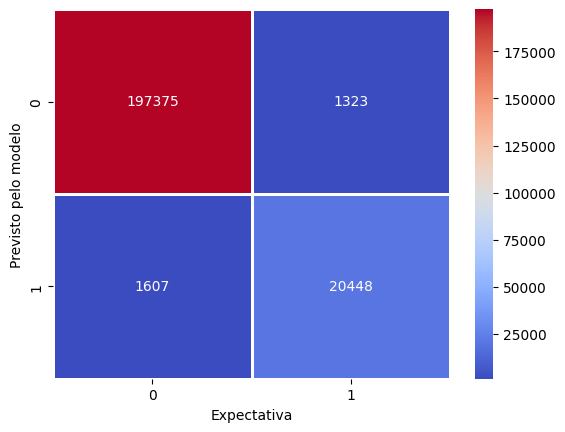


Métricas:

Acurácia: 98.672725%
Precisão: 93.923109%
Recall:  92.713670%
F1 Score:  93.314471%
MCC:  92.580128%


In [35]:
cf_matrix = confusion_matrix(y_train_sm_1090, y_pred_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print("\nMétricas:\n")
print(f'Acurácia: {accuracy_score(y_train_sm_1090, y_pred_curl):%}')
print(f'Precisão: {precision_score(y_train_sm_1090, y_pred_curl):%}')
print(f'Recall:  {recall_score(y_train_sm_1090, y_pred_curl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_1090, y_pred_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_1090, y_pred_curl):%}')

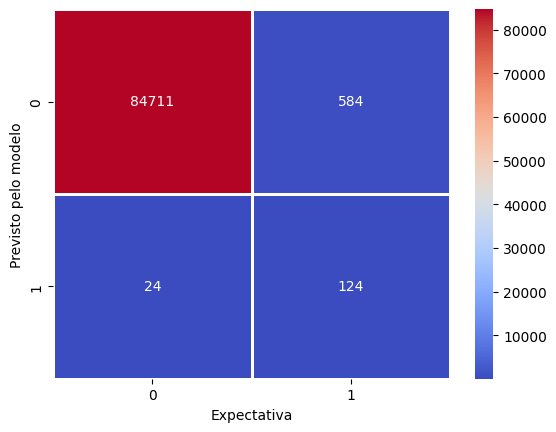


Métricas:

Acurácia: 99.288414%
Precisão: 17.514124%
Recall:  83.783784%
F1 Score:  28.971963%
MCC:  38.118950%


In [36]:
cf_matrix = confusion_matrix(y_test, resultado_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print("\nMétricas:\n")
print(f'Acurácia: {accuracy_score(y_test, resultado_curl):%}')
print(f'Precisão: {precision_score(y_test, resultado_curl):%}')
print(f'Recall:  {recall_score(y_test, resultado_curl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_curl):%}')

0.9602391789319725 0.9154955060576726


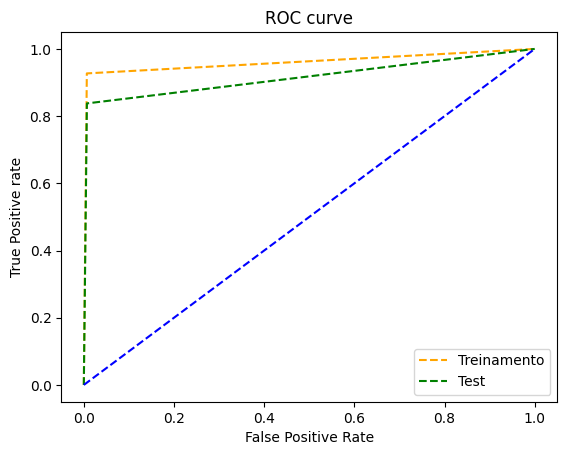

In [38]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_1090, y_pred_curl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_curl, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_train_sm_1090, y_pred_curl)
auc_score2 = roc_auc_score(y_test, resultado_curl)

print(auc_score1, auc_score2)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#**MODELOS TREINAMENTO 50:50**

#####**MODELO 1 SCIKIT LEARN PURO**

In [15]:
model = LogisticRegression(solver='saga', max_iter=6000, class_weight={0: 1, 1: 10}, verbose=True, n_jobs=100) #Quanto maior o número de iterações, melhor o resultado
model.fit(X_train_sm_5050,y_train_sm_5050)
y_pred_rl = model.predict(X_train_sm_5050)

print(classification_report(y_train_sm_5050, y_pred_rl))

[Parallel(n_jobs=100)]: Using backend ThreadingBackend with 100 concurrent workers.


KeyboardInterrupt: 

In [ ]:
dft = pd.DataFrame(data = X_test)
print(dft)
resultado_rl = model.predict(dft)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .

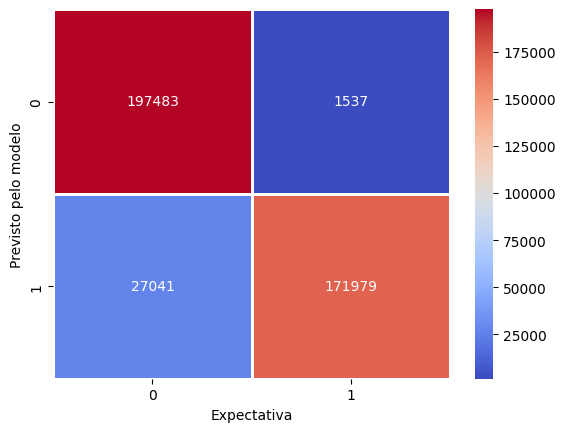


Métricas

Acurácia: 92.820320%
Precisão: 99.114203%
Recall:  86.412923%
F1 Score:  92.328795%
MCC:  86.352611%


In [ ]:
cf_matrix = confusion_matrix(y_train_sm_5050, y_pred_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print("\nMétricas\n")
print(f'Acurácia: {accuracy_score(y_train_sm_5050, y_pred_rl):%}')
print(f'Precisão: {precision_score(y_train_sm_5050, y_pred_rl):%}')
print(f'Recall:  {recall_score(y_train_sm_5050, y_pred_rl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_5050, y_pred_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_5050, y_pred_rl):%}')

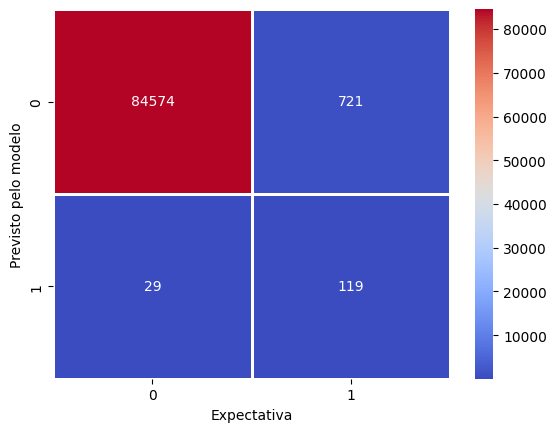

In [ ]:
cf_matrix = confusion_matrix(y_test, resultado_rl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print("\nMétricas\n")
print(f'Acurácia: {accuracy_score(y_test, resultado_rl):%}')
print(f'Precisão: {precision_score(y_test, resultado_rl):%}')
print(f'Recall:  {recall_score(y_test, resultado_rl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_rl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_rl):%}')

0.5493658461344307 0.8978005190253856


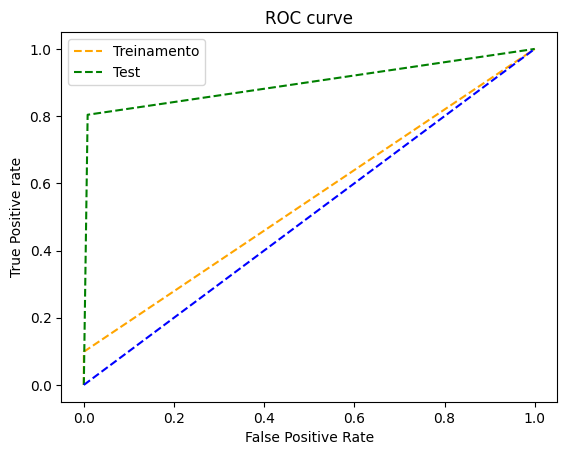

In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_5050, y_pred_rl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_rl, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_train_sm_5050, y_pred_rl)
auc_score2 = roc_auc_score(y_test, resultado_rl)

print(auc_score1, auc_score2)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#####**MODELO 2 CUML**

In [19]:
from sklearn.metrics import classification_report

model = cuLogisticRegression(solver='qn', verbose=True)  # qn é equivalente ao saga #epochs=129
model.fit(X_train_sm_5050, y_train_sm_5050)
y_pred_curl = model.predict(X_train_sm_5050)

print(classification_report(y_train_sm_5050, y_pred_curl))

[2025-06-27 02:15:25.257] [CUML] [debug] CY::Estimator parameters:
[2025-06-27 02:15:25.261] [CUML] [debug] {'C': 1.0,
 '_full_kwargs': {'max_iter': 10000, 'solver': 'qn', 'verbose': True},
 '_input_mem_type': None,
 '_input_type': None,
 '_verbose': 5,
 'class_weight': CumlArrayDescriptorMeta(input_type=None, values={None: None}),
 'fit_intercept': True,
 'handle': <pylibraft.common.handle.Handle object at 0x7e2f305a3d80>,
 'l1_ratio': None,
 'linesearch_max_iter': 50,
 'max_iter': 10000,
 'n_features_in_': None,
 'output_mem_type': <MemoryType.device: 1>,
 'output_type': 'input',
 'penalty': 'l2',
 'solver': 'qn',
 'solver_model': QN(),
 'target_dtype': None,
 'tol': 0.0001,
 'verb_prefix': 'CY::'}
[2025-06-27 02:15:25.274] [CUML] [debug] CY::Setting loss to sigmoid
[2025-06-27 02:15:25.274] [CUML] [debug] CY::Calling QN fit sigmoid
[2025-06-27 02:15:25.397] [CUML] [debug] Running L-BFGS
[2025-06-27 02:15:25.401] [CUML] [debug] 0000: f(x)=0.69314718 conv.crit=4782.10506551 (gnorm=331

In [21]:
from sklearn.metrics import log_loss
from sklearn.datasets import make_classification


dft = pd.DataFrame(data = X_test)
print(dft)
resultado_curl = model.predict(dft)

            Time        V1        V2        V3        V4        V5        V6  \
186882  127294.0 -2.537331  1.890864 -0.840555 -1.102759 -2.105725  0.367811   
165754  117632.0 -0.250839  1.104108  0.206089  0.417324  1.204079 -0.350694   
235285  148330.0  0.568980 -2.520416 -1.114138  1.670652 -1.128945  0.398822   
101271   67778.0  1.328892  0.226908 -0.308968  0.381772  0.238490 -0.282946   
5832      6308.0  1.124863 -0.165691  1.337053  1.030033 -0.891116  0.202926   
...          ...       ...       ...       ...       ...       ...       ...   
64725    51279.0 -1.808185  1.328808 -0.991449 -2.473986  2.185095  3.496806   
16688    28048.0 -0.442905  0.716727  1.256775  0.860048  1.210872  1.066390   
183868  125990.0  2.092418 -0.931315 -1.553089 -1.131369 -0.197801 -0.373117   
45011    42168.0  1.293234  0.097565 -0.209304  0.329036  0.034958 -0.145507   
150527   93609.0  2.214016 -0.584030 -1.238673 -0.702993 -0.184492 -0.646248   

              V7        V8        V9  .

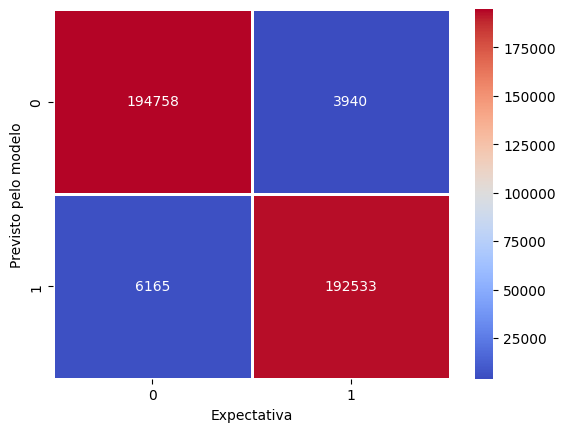

Acurácia: 97.457196%
Precisão: 97.994635%
Recall:  96.897301%
F1 Score:  97.442879%
MCC:  94.920344%


In [22]:
cf_matrix = confusion_matrix(y_train_sm_5050, y_pred_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print(f'Acurácia: {accuracy_score(y_train_sm_5050, y_pred_curl):%}')
print(f'Precisão: {precision_score(y_train_sm_5050, y_pred_curl):%}')
print(f'Recall:  {recall_score(y_train_sm_5050, y_pred_curl):%}')
print(f'F1 Score:  {f1_score(y_train_sm_5050, y_pred_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_train_sm_5050, y_pred_curl):%}')

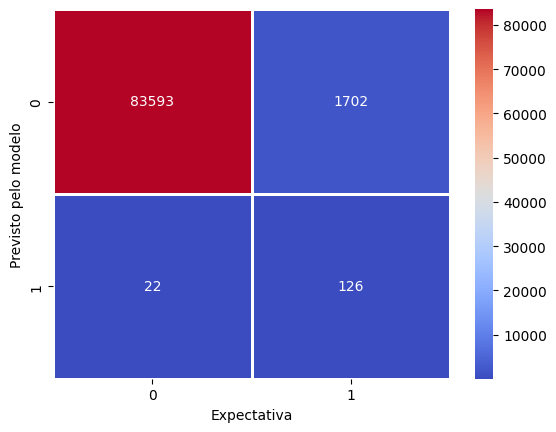

Acurácia: 97.982281%
Precisão: 6.892779%
Recall:  85.135135%
F1 Score:  12.753036%
MCC:  23.893014%


In [23]:
cf_matrix = confusion_matrix(y_test, resultado_curl)
sn.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.xlabel('Expectativa')
plt.ylabel('Previsto pelo modelo')
plt.show()

print(f'Acurácia: {accuracy_score(y_test, resultado_curl):%}')
print(f'Precisão: {precision_score(y_test, resultado_curl):%}')
print(f'Recall:  {recall_score(y_test, resultado_curl):%}')
print(f'F1 Score:  {f1_score(y_test, resultado_curl):%}')
print(f'MCC:  {matthews_corrcoef(y_test, resultado_curl):%}')

0.9745719634822696 0.9156985375081395


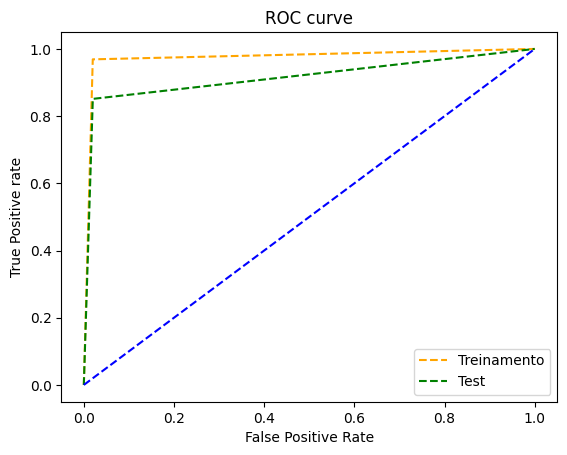

In [24]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_train_sm_5050, y_pred_curl, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, resultado_curl, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_train_sm_5050, y_pred_curl)
auc_score2 = roc_auc_score(y_test, resultado_curl)

print(auc_score1, auc_score2)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Treinamento')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Test')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();